# Load module

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import joblib
import math
import os
import glob

print(os.listdir("../../../data/house"))
print(glob.glob('*.pkl'))

['ames_shallow_fe.pickle', 'ames.pickle', 'ames_shallow_fe_indexers.pickle', 'descriptions.pickle', 'ames.csv', 'description.txt']
[]


# Load data

In [3]:
filename = '../../../data/house/ames_shallow_fe.pickle'
df = joblib.load(filename)
df.head(3)

p_i_d  area   price m_s_sub_class  m_s_zoning  lot_frontage  lot_area  \
0  526350040   896  105000            20           0          80.0     11622   
1  526351010  1329  172000            20           1          81.0     14267   
2  526353030  2110  244000            20           1          93.0     11160   

   lot_shape  land_contour  lot_config  ...  pool_area  fence  misc_feature  \
0          0             0           0  ...          0      0             0   
1          1             0           1  ...          0      1             1   
2          0             0           1  ...          0      1             0   

   misc_val  mo_sold  yr_sold  sale_type  sale_condition  log_price  total_s_f  
0         0        6     2010          0               0  11.561725     1778.0  
1     12500        6     2010          0               0  12.055256     2658.0  
2         0        4     2010          0               0  12.404928     4220.0  

[3 rows x 79 columns]

In [4]:
# EBM 은  NA를 용납하지 않는다...
df = df.dropna()
df.shape

(2885, 79)

# EBM modeling

In [5]:
# interpretml EBM
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.data import Marginal
from interpret import show

In [6]:
X = df.drop(['p_i_d','price','log_price'], axis=1)
X.head(3)

area m_s_sub_class  m_s_zoning  lot_frontage  lot_area  lot_shape  \
0   896            20           0          80.0     11622          0   
1  1329            20           1          81.0     14267          1   
2  2110            20           1          93.0     11160          0   

   land_contour  lot_config  land_slope  neighborhood  ...  screen_porch  \
0             0           0           0             0  ...           120   
1             0           1           0             0  ...             0   
2             0           1           0             0  ...             0   

   pool_area  fence  misc_feature  misc_val  mo_sold  yr_sold  sale_type  \
0          0      0             0         0        6     2010          0   
1          0      1             1     12500        6     2010          0   
2          0      1             0         0        4     2010          0   

   sale_condition  total_s_f  
0               0     1778.0  
1               0     2658.0  
2               0     4220.0  

[3 rows x 76 columns]

In [7]:
y = df['price']

In [20]:
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X, y)

ExplainableBoostingRegressor(feature_names=['area', 'm_s_sub_class',
                                            'm_s_zoning', 'lot_frontage',
                                            'lot_area', 'lot_shape',
                                            'land_contour', 'lot_config',
                                            'land_slope', 'neighborhood',
                                            'condition1', 'condition2',
                                            'bldg_type', 'house_style',
                                            'overall_qual', 'overall_cond',
                                            'year_built', 'year_remod_add',
                                            'roof_style', 'roof_matl',
                                            'exterior1st', 'exterior2nd',
                                            'mas_vnr_ty...
                                            'continuous', 'continuous',
                                            'continuous', 'continuou

# utils example

In [21]:
import sys
sys.path.append("../../../utils/")

import utils

global_df=utils.get_global_df(X, ebm)

In [24]:
global_df[global_df.col_name=="area"]

names        scores  upper_bounds  lower_bounds col_name
0     334.0  -8815.015944  -7443.685727 -10186.346161     area
1     608.5  -6757.131885  -5991.346221  -7522.917549     area
2     650.5  -6757.131885  -5991.346221  -7522.917549     area
3     696.0  -6757.131885  -5991.346221  -7522.917549     area
4     730.5  -6161.259818   -5554.76579  -6767.753845     area
..      ...           ...           ...           ...      ...
251  2788.5  19553.707226  22961.760583   16145.65387     area
252  2827.0  19887.195956  23577.097584  16197.294328     area
253  2967.0  25270.025963    28420.2801  22119.771826     area
254  3233.0  39642.595711  45497.924112   33787.26731     area
255  4476.0  39642.595711  45497.924112   33787.26731     area

[256 rows x 5 columns]

In [16]:
global_df.groupby("col_name").apply(lambda x: x.scores.mean())

col_name
area               514.877395
bedroom_abv_gr   -1469.415930
bldg_type        -2774.326400
bsmt_cond         1418.309145
bsmt_exposure     1626.855475
                     ...     
x2nd_flr_s_f      2768.438178
x3_ssn_porch      3802.581754
year_built       -1066.772954
year_remod_add   -1724.624049
yr_sold            -59.519900
Length: 76, dtype: float64

In [25]:
score_df=utils.get_score_variance_table(global_df, ebm)

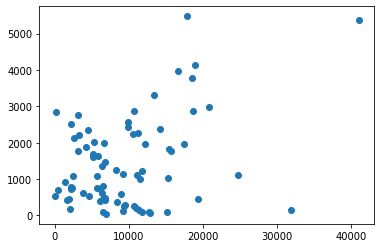

In [30]:
plt.scatter(x=score_df.max_min_gap_excld_extrm, y=score_df.feature_importance)

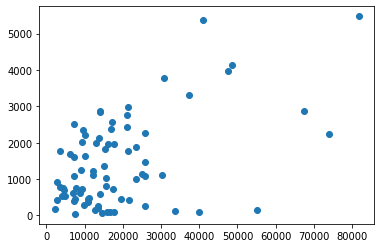

In [29]:
plt.scatter(x=score_df.max_min_gap, y=score_df.feature_importance)

In [33]:
score_df.sort_values("max_min_gap",ascending=False).head(20)

min           max   max_min_gap  \
col_name                                                   
prediction      -4090.588249  77724.286199  81814.874448   
x2nd_flr_s_f    -4370.864563  69647.902638  74018.767201   
bsmt_fin_s_f1   -3334.596350  64148.652657  67483.249007   
pool_area       -8196.621870  46945.221218  55141.843088   
area            -8815.015944  39642.595711  48457.611655   
total_s_f       -7514.396464  40101.806132  47616.202596   
overall_qual   -10457.034475  30654.237425  41111.271901   
condition2      -9856.038939  30023.339850  39879.378790   
total_bsmt_s_f  -5158.287634  32172.481915  37330.769549   
roof_matl       -1282.865782  32333.375476  33616.241258   
x1st_flr_s_f    -9760.032663  21069.308250  30829.340913   
functional     -29580.683219    591.433539  30172.116758   
bsmt_fin_s_f2   -4475.467583  21395.144822  25870.612404   
lot_frontage    -5222.836416  20598.782672  25821.619088   
open_porch_s_f -11250.923719  14551.067536  25801.991256   
garage_area    -11640.422132  14112.790392  25753.212524   
mas_vnr_area    -2491.611498  22458.792649  24950.404147   
garage_yr_blt  -16216.139218   7322.373766  23538.512985   
screen_porch    -2752.150760  20654.212616  23406.363377   
enclosed_porch -14125.415556   7571.695877  21697.111433   

                max_min_gap_excld_extrm  feature_importance           std  
col_name                                                                   
prediction                 17902.846542         5477.295276  10340.361326  
x2nd_flr_s_f               10613.241385         2236.055024   7059.091727  
bsmt_fin_s_f1              18665.360868         2880.535780   7310.578899  
pool_area                  31926.890223          151.203374  16171.504332  
area                       19014.785492         4132.991404   6610.109880  
total_s_f                  16645.668697         3975.148866   6317.362560  
overall_qual               41066.839451         5361.316665  16275.001403  
condition2                  6562.226429           86.458612  13663.846053  
total_bsmt_s_f             13413.677773         3323.727707   5225.522022  
roof_matl                   9284.332739          124.336581  12773.236715  
x1st_flr_s_f               18607.596303         3783.081556   5276.972344  
functional                 24707.525894         1106.195971  11307.454030  
bsmt_fin_s_f2               9342.709104          251.309427   3870.310218  
lot_frontage                5769.484861         1081.628921   3592.459328  
open_porch_s_f              6766.853055         1470.564581   2485.206410  
garage_area                11224.896568         2271.824442   4187.928252  
mas_vnr_area                9279.484894         1125.868656   3886.326203  
garage_yr_blt               4202.723527         1871.792311   3137.115975  
screen_porch               11514.743610         1009.702427   4386.260978  
enclosed_porch              6819.601081          423.339756   2707.481898

In [34]:
score_df.sort_values("feature_importance",ascending=False).head(20)

min           max   max_min_gap  \
col_name                                                   
prediction      -4090.588249  77724.286199  81814.874448   
overall_qual   -10457.034475  30654.237425  41111.271901   
area            -8815.015944  39642.595711  48457.611655   
total_s_f       -7514.396464  40101.806132  47616.202596   
x1st_flr_s_f    -9760.032663  21069.308250  30829.340913   
total_bsmt_s_f  -5158.287634  32172.481915  37330.769549   
overall_cond   -14968.762995   6278.033879  21246.796874   
bsmt_fin_s_f1   -3334.596350  64148.652657  67483.249007   
neighborhood    -3056.704985  11090.943125  14147.648110   
exter_qual      -2323.290309  11599.022992  13922.313301   
full_bath       -3053.428291  17972.030222  21025.458514   
year_built      -8321.790651   8944.204122  17265.994773   
bsmt_fin_type1  -2998.591010   4114.572625   7113.163635   
year_remod_add -14848.042634   6320.791054  21168.833688   
lot_area        -8529.982987   8353.484815  16883.467801   
half_bath       -6306.968679   3244.160068   9551.128748   
garage_area    -11640.422132  14112.790392  25753.212524   
x2nd_flr_s_f    -4370.864563  69647.902638  74018.767201   
bsmt_exposure   -1540.743606   8597.373208  10138.116814   
kitchen_qual    -2003.196459  11725.363039  13728.559498   

                max_min_gap_excld_extrm  feature_importance           std  
col_name                                                                   
prediction                 17902.846542         5477.295276  10340.361326  
overall_qual               41066.839451         5361.316665  16275.001403  
area                       19014.785492         4132.991404   6610.109880  
total_s_f                  16645.668697         3975.148866   6317.362560  
x1st_flr_s_f               18607.596303         3783.081556   5276.972344  
total_bsmt_s_f             13413.677773         3323.727707   5225.522022  
overall_cond               20802.016506         2977.322160   9223.187384  
bsmt_fin_s_f1              18665.360868         2880.535780   7310.578899  
neighborhood               10711.203821         2860.610713   4281.697935  
exter_qual                   175.498455         2847.540566   5027.953202  
full_bath                   3192.438554         2753.906556   7195.490734  
year_built                  9845.901546         2572.782734   3170.215116  
bsmt_fin_type1              2255.070796         2509.743092   2130.047484  
year_remod_add              9885.314497         2430.858720   3237.015953  
lot_area                   14199.445177         2387.718895   3701.910719  
half_bath                   4534.284095         2343.441796   4552.804223  
garage_area                11224.896568         2271.824442   4187.928252  
x2nd_flr_s_f               10613.241385         2236.055024   7059.091727  
bsmt_exposure               3264.207908         2207.173137   3730.987900  
kitchen_qual                2663.111474         2141.346000   5491.369058

In [9]:
appended_df=utils.append_prediction(X, ebm)

In [12]:
appended_df

area m_s_sub_class  m_s_zoning  lot_frontage  lot_area  lot_shape  \
0      896            20           0          80.0     11622          0   
1     1329            20           1          81.0     14267          1   
2     2110            20           1          93.0     11160          0   
3     1629            60           1          74.0     13830          1   
4     1604            60           1          78.0      9978          1   
...    ...           ...         ...           ...       ...        ...   
2883  1003            80           1          37.0      7937          1   
2884   902            20           1          74.0      8885          1   
2885   970            85           1          62.0     10441          0   
2886  1389            20           1          77.0     10010          0   
2887  2000            60           1          74.0      9627          0   

      land_contour  lot_config  land_slope  neighborhood  ...  pool_area  \
0                0           0           0             0  ...          0   
1                0           1           0             0  ...          0   
2                0           1           0             0  ...          0   
3                0           0           0             1  ...          0   
4                0           0           0             1  ...          0   
...            ...         ...         ...           ...  ...        ...   
2883             0           2           0            22  ...          0   
2884             3           0           1            22  ...          0   
2885             0           0           0            22  ...          0   
2886             0           0           1            22  ...          0   
2887             0           0           1            22  ...          0   

      fence  misc_feature  misc_val  mo_sold  yr_sold  sale_type  \
0         0             0         0        6     2010          0   
1         1             1     12500        6     2010          0   
2         1             0         0        4     2010          0   
3         0             0         0        3     2010          0   
4         1             0         0        6     2010          0   
...     ...           ...       ...      ...      ...        ...   
2883      2             0         0        3     2006          0   
2884      0             0         0        6     2006          0   
2885      0             2       700        7     2006          0   
2886      1             0         0        4     2006          0   
2887      1             0         0       11     2006          0   

      sale_condition  total_s_f     prediction  
0                  0     1778.0  122522.794802  
1                  0     2658.0  172328.394113  
2                  0     4220.0  252184.935025  
3                  0     2557.0  191642.478788  
4                  0     2530.0  197901.453618  
...              ...        ...            ...  
2883               0     2006.0  146037.340948  
2884               0     1766.0  131350.637429  
2885               0     1882.0  128563.772991  
2886               0     2778.0  165495.509123  
2887               0     2996.0  211404.289189  

[2885 rows x 77 columns]

In [9]:
fi_df=utils.get_feature_importance_df(X, ebm)

In [13]:
fi_df

feature   importance
0                         area  4334.164235
1                m_s_sub_class  2277.138013
2                   m_s_zoning  1782.596624
3                 lot_frontage  1175.695527
4                     lot_area  2541.987084
..                         ...          ...
72                     yr_sold   921.884295
73                   sale_type   876.691056
74              sale_condition  1135.084390
75                   total_s_f  4169.760967
76  year_remod_add x total_s_f   569.527935

[77 rows x 2 columns]